In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
import pandas as pd
import seaborn as sns
device = torch.device("cuda:0")

In [91]:
# Define a simple Multilayer Perceptron (MLP) model
#Simple feedforward ANN for decoding kinematics

class model_ann(nn.Module):
    def __init__(self, input_size, output_size, layer_size, device):
        super(model_ann, self).__init__()
        self.input_size,  self.layer_size, self.output_size = input_size, layer_size, output_size
        self.device = device

        #List layer sizes
        self.layer_hidden = np.concatenate([[input_size], layer_size])

        # Initialize masking dict
        self.mask_list = None
        self.unit_lookup = None
        self.reset_mask()
        assert len(self.mask_list) == len(layer_size)

         
        #Compile layers into lists
        self.layer_list = nn.ModuleList(
            [nn.Linear(in_features=self.layer_hidden[idx], out_features=self.layer_hidden[idx+1]) for idx in range(len(self.layer_hidden)-1)])

        self.fc = nn.Linear(self.layer_size[-1], self.output_size)

    def update_mask(self, mask_units):
        self.reset_mask()
        for mask_unit in mask_units:
            unit_idx = self.unit_lookup[mask_unit]['unit']
            layer_idx = self.unit_lookup[mask_unit]['layer']

            self.mask_list[layer_idx][unit_idx] = False


    def reset_mask(self):
        # Lookup table for masked units
        self.mask_list = list()
        self.unit_lookup = dict()
        unit_count= 0
        for layer_idx in range(len(self.layer_size)):
            num_units = self.layer_size[layer_idx]
            mask_tensor = torch.tensor(np.repeat(True, num_units)).to(self.device)
            self.mask_list.append(mask_tensor)
            for unit_idx in range(num_units):
                self.unit_lookup[unit_count] = {'layer': layer_idx, 'unit': unit_idx}
                unit_count += 1

 
    def forward(self, x):
        x = x.view(x.size(0), -1)
        #Encoding step
        x_list = list()
        for idx in range(len(self.layer_list)):
            x = torch.tanh(self.layer_list[idx](x))
            x_list.append(x.detach().cpu().numpy())

            mask = self.mask_list[idx].tile((x.size(0)), 1)
            x = x * mask


        #Decoding step
        x = self.fc(x)

        return x, x_list


In [92]:
# Download and prepare the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)

test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform)


In [95]:
# Create data loaders for training and validation
batch_size = 1000
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)

# Initialize the MLP model and set up the loss function and optimizer
input_size = 28*28
output_size = 10
layer_size=[128, 64, 64, 64, 64, 64, 64, 64, 64]
model = model_ann(input_size, output_size, layer_size=layer_size, device=device).to(device)
criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [96]:

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(images.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")




Epoch 1, Loss: 1.6784669915835062
Epoch 2, Loss: 0.8918580094973246
Epoch 3, Loss: 0.4130091205239296
Epoch 4, Loss: 0.24791285768151283
Epoch 5, Loss: 0.18691739837328594
Epoch 6, Loss: 0.15655371658504008
Epoch 7, Loss: 0.1338412361840407
Epoch 8, Loss: 0.13139935160676638
Epoch 9, Loss: 0.10918868357936541
Epoch 10, Loss: 0.0989277674506108


In [97]:
# Validation
model.eval()
predicted_labels = list()
true_labels = list()
activations_list = list()

with torch.no_grad():
    for images, labels in test_loader:
        outputs, activations_batch = model(images.to(device))
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.detach().cpu().numpy())
        true_labels.extend(labels.detach().cpu().numpy())
        activations_list.append(activations_batch)

true_labels = np.array(true_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

Validation Accuracy: 96.17%


In [99]:
activations = np.concatenate([np.concatenate(act, axis=1) for act in activations_list], axis=0)
num_trials, num_neurons = activations.shape

# label_mask = true_labels == 5
# activations = activations[label_mask,:]


In [100]:

trial_dists = list()
for neuron_idx in range(num_neurons):
    dists = pdist(activations[:500,neuron_idx].reshape(-1,1), 'euclidean')
    trial_dists.append(dists)
trial_dists = np.array(trial_dists)


In [101]:
neuron_dists = squareform(pdist(trial_dists, 'correlation'))

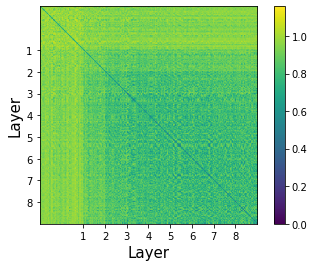

In [102]:
plt.imshow(neuron_dists)
plt.xlabel('Layer', fontsize=15)
plt.ylabel('Layer', fontsize=15)
plt.xticks(ticks=np.cumsum(layer_size)[:-1], labels=list(range(1, len(layer_size))))
plt.yticks(ticks=np.cumsum(layer_size)[:-1], labels=list(range(1, len(layer_size))))


plt.colorbar()

In [133]:
tsne = TSNE(n_components=2, perplexity=30, random_state=0, metric='precomputed', init='random')
points = tsne.fit_transform(neuron_dists)
kmeans_labels = KMeans(n_clusters=6, random_state=0).fit(points)

/home/nick/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/nick/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:819: FutureWarning: 'square_distances' has been introduced in 0.24 to help phase out legacy squaring behavior. The 'legacy' setting will be removed in 1.1 (renaming of 0.26), and the default setting will be changed to True. In 1.3, 'square_distances' will be removed altogether, and distances will be squared by default. Set 'square_distances'=True to silence this warning.
  warnings.warn(


In [134]:
layer_ids = np.repeat(np.arange(len(layer_size)), layer_size)
df_dict = {'unit': list(range(num_neurons)), 'TSNE1': points[:,0], 'TSNE2': points[:,1],'layer': layer_ids, 'cluster': kmeans_labels.labels_}
df = pd.DataFrame(df_dict)

Text(0, 0.5, 'TSNE2')

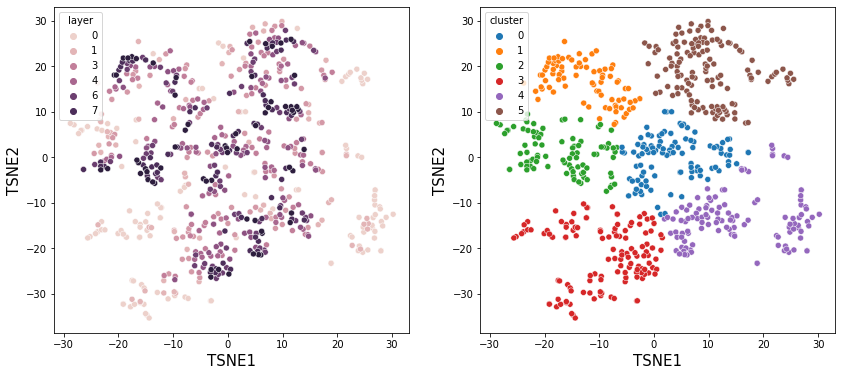

In [135]:
plt.figure(figsize=(14, 6))
plt.subplot(1,2,1)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='layer')
plt.xlabel('TSNE1', fontsize=15)
plt.ylabel('TSNE2', fontsize=15)

plt.subplot(1,2,2)
sns.scatterplot(data=df, x='TSNE1', y='TSNE2', hue='cluster', palette='tab10')
plt.xlabel('TSNE1', fontsize=15)
plt.ylabel('TSNE2', fontsize=15)

In [136]:
def mask_accuracy(model, mask_units):
    model.eval()

    model.update_mask(mask_units)
    predicted_labels = list()
    true_labels = list()
    activations_list = list()

    with torch.no_grad():
        for images, labels in test_loader:
            outputs, activations_batch = model(images.to(device))
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.detach().cpu().numpy())
            true_labels.extend(labels.detach().cpu().numpy())
            activations_list.append(activations_batch)

    true_labels = np.array(true_labels)
    accuracy = accuracy_score(true_labels, predicted_labels)
    return accuracy

### Investigate role of layer position in deleting neurons

In [165]:
delete_size = 300
random_delete = list()
deep_layer_delete = list()
shallow_layer_delete = list()

deep_df = df[df['layer'] >= 4]
shallow_df = df[df['layer'] < 4]

delete_size_list = [10, 50, 100, 150, 200]
for delete_size in delete_size_list:
    random_delete_temp, deep_layer_delete_temp, shallow_layer_delete_temp = list(), list(), list()
    for idx in range(5):
        random_units = np.random.randint(0, num_neurons, size=delete_size)
        deep_units = np.random.choice(deep_df['unit'].values, size=delete_size, replace=False)
        shallow_units = np.random.choice(shallow_df['unit'].values, size=delete_size, replace=False)

        random_delete_temp.append(mask_accuracy(model, random_units))
        deep_layer_delete_temp.append(mask_accuracy(model, deep_units))
        shallow_layer_delete_temp.append(mask_accuracy(model, shallow_units))

    random_delete.append(random_delete_temp)
    deep_layer_delete.append(deep_layer_delete_temp)
    shallow_layer_delete.append(shallow_layer_delete_temp)

random_delete = np.array(random_delete).T
deep_layer_delete = np.array(deep_layer_delete).T
shallow_layer_delete = np.array(shallow_layer_delete).T



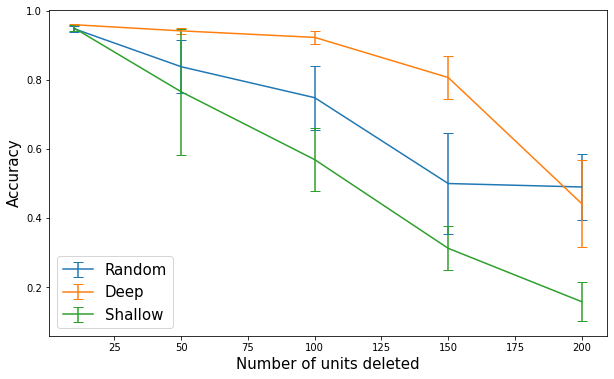

In [166]:

plt.figure(figsize=(10, 6))
plt.errorbar(delete_size_list, random_delete.mean(axis=0), yerr=np.std(random_delete, axis=0), capsize=5, label='Random')
plt.errorbar(delete_size_list, deep_layer_delete.mean(axis=0), yerr=np.std(deep_layer_delete, axis=0), capsize=5, label='Deep')
plt.errorbar(delete_size_list, shallow_layer_delete.mean(axis=0), yerr=np.std(shallow_layer_delete, axis=0), capsize=5, label='Shallow')
plt.xlabel('Number of units deleted', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(fontsize=15)

In [147]:
# df_filtered = df[df['layer'] > 4]
cluster_size = df.groupby('cluster').count()['unit'].values
cluster_size
# min_neurons

array([100,  80,  87, 128, 116, 129])

In [163]:
cluster_delete = list()
for cluster_idx in range(6):
    df_filtered = df[df['layer'] < 2]
    cluster_units = df_filtered[df_filtered['cluster'] == cluster_idx]['unit'].values
    cluster_units = np.random.choice(cluster_units, size=10, replace=False)
    # print(len(cluster_units))
    
    cluster_delete.append(mask_accuracy(model, cluster_units))


In [164]:
cluster_delete

[0.9182, 0.9338, 0.9009, 0.8478, 0.9426, 0.9543]

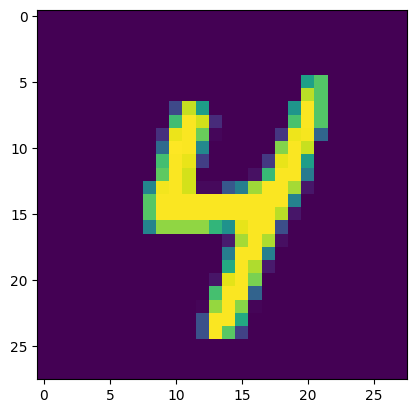

In [ ]:
plt.imshow(images[3,0,:,:])

In [ ]:
activations[2].size()

torch.Size([16, 64])